In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/Enron.csv')

In [ ]:
df.columns

Index(['subject', 'body', 'label'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import json
import re
from openai import OpenAI
import time
from collections import Counter
import random

# Initialize OpenAI client
try:
    from google.colab import userdata
    api_key = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=api_key)
    print(" OpenAI client initialized ")
except ImportError:
    # Fallback for non-Colab environments
    import os
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    print(" OpenAI client initialized with environment variable")

# Load your Enron dataset (assuming it's already loaded as 'df')
# df = pd.read_csv('/content/Enron.csv')

def detect_urls_in_emails(df):
    """Use regex to detect URLs in email subject and body"""
    # Comprehensive URL detection regex patterns
    url_patterns = [
        r'http[s]?://[^\s]+',  # http/https URLs
        r'www\.[^\s]+',        # www URLs
        r'[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(?:/[^\s]*)?',  # domain.com patterns
        r'ftp://[^\s]+',       # FTP URLs
        r'mailto:[^\s]+',      # mailto links
    ]

    combined_pattern = '|'.join(url_patterns)

    # Check both subject and body for URLs
    df['subject_has_url'] = df['subject'].str.contains(combined_pattern, case=False, na=False, regex=True)
    df['body_has_url'] = df['body'].str.contains(combined_pattern, case=False, na=False, regex=True)
    df['has_url'] = df['subject_has_url'] | df['body_has_url']

    # Extract actual URLs for analysis
    def extract_urls(text):
        if pd.isna(text):
            return []
        urls = re.findall(combined_pattern, str(text), re.IGNORECASE)
        return urls

    df['extracted_urls'] = df['body'].apply(extract_urls)
    df['url_count'] = df['extracted_urls'].apply(len)

    return df

def analyze_dataset(df):
    """Analyze the dataset structure and distribution"""
    print("=== DATASET ANALYSIS ===")
    print(f"Total samples: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Label distribution: {df['label'].value_counts()}")
    print(f"Missing values: {df.isnull().sum()}")

    # Detect URLs using regex
    df = detect_urls_in_emails(df)

    print(f"\n=== URL ANALYSIS ===")
    print(f"Emails with URLs: {df['has_url'].sum()} ({df['has_url'].mean()*100:.1f}%)")
    print(f"URLs by class:")
    for label in [0, 1]:
        class_name = "Safe" if label == 0 else "Phishing"
        class_df = df[df['label'] == label]
        url_count = class_df['has_url'].sum()
        url_pct = class_df['has_url'].mean() * 100
        print(f"  {class_name}: {url_count} emails with URLs ({url_pct:.1f}%)")

    # Calculate email lengths
    df['body_length'] = df['body'].str.len()
    df['subject_length'] = df['subject'].str.len()

    print(f"\n=== LENGTH ANALYSIS ===")
    print(f"Body length stats: {df['body_length'].describe()}")
    print(f"Subject length stats: {df['subject_length'].describe()}")

    # Show some example URLs found
    sample_urls = df[df['has_url']]['extracted_urls'].head(5)
    print(f"\n=== SAMPLE URLs DETECTED ===")
    for i, urls in enumerate(sample_urls):
        if urls:
            print(f"Email {i+1}: {urls[:2]}")  # Show first 2 URLs

    return df

def categorize_email_length(length):
    """Categorize emails by length"""
    if length <= 500:
        return 'short'
    elif length <= 2000:
        return 'medium'
    else:
        return 'long'

def select_diverse_samples(df, samples_per_class=2000):
    """Select diverse samples for each class"""
    print("\n=== SELECTING DIVERSE SAMPLES ===")

    # Add length categories
    df['length_category'] = df['body_length'].apply(categorize_email_length)

    selected_samples = []

    for label in [0, 1]:
        label_name = "Safe" if label == 0 else "Phishing"
        print(f"\nSelecting {samples_per_class} samples for {label_name} emails...")

        class_df = df[df['label'] == label].copy()

        if len(class_df) < samples_per_class:
            print(f"Warning: Only {len(class_df)} samples available for class {label}")
            selected = class_df
        else:
            # Check URL availability in this class
            urls_available = class_df['has_url'].sum()
            url_percentage = urls_available / len(class_df) * 100
            print(f"  URLs available in {label_name}: {urls_available} ({url_percentage:.1f}%)")

            selected = []

            # Target distribution: 40% short, 40% medium, 20% long
            targets = {
                'short': int(samples_per_class * 0.4),
                'medium': int(samples_per_class * 0.4),
                'long': int(samples_per_class * 0.2)
            }

            for length_cat, target_count in targets.items():
                cat_df = class_df[class_df['length_category'] == length_cat]

                if len(cat_df) < target_count:
                    selected.extend(cat_df.to_dict('records'))
                    print(f"  {length_cat}: {len(cat_df)} samples (all available)")
                else:
                    # Try to include URL diversity if URLs are available
                    with_urls = cat_df[cat_df['has_url'] == True]
                    without_urls = cat_df[cat_df['has_url'] == False]

                    if len(with_urls) > 0:
                        # Aim for 30% with URLs if available
                        url_target = min(int(target_count * 0.3), len(with_urls))
                        no_url_target = target_count - url_target

                        selected.extend(with_urls.sample(url_target, random_state=42).to_dict('records'))

                        if len(without_urls) >= no_url_target:
                            selected.extend(without_urls.sample(no_url_target, random_state=42).to_dict('records'))
                        else:
                            selected.extend(without_urls.to_dict('records'))
                            # Fill remaining with any available
                            remaining = target_count - len(without_urls) - url_target
                            if remaining > 0 and len(with_urls) > url_target:
                                additional = min(remaining, len(with_urls) - url_target)
                                selected.extend(with_urls.iloc[url_target:url_target+additional].to_dict('records'))

                        print(f"  {length_cat}: {target_count} samples (with {url_target} URL samples)")
                    else:
                        # No URLs available, just random selection
                        selected.extend(cat_df.sample(target_count, random_state=42).to_dict('records'))
                        print(f"  {length_cat}: {target_count} samples (no URLs available)")

            selected = pd.DataFrame(selected)

        selected_samples.append(selected)
        print(f"Total selected for {label_name}: {len(selected)}")

    # Combine and shuffle
    final_df = pd.concat(selected_samples, ignore_index=True)
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n=== FINAL SELECTION STATS ===")
    print(f"Total samples: {len(final_df)}")
    print(f"Label distribution: {final_df['label'].value_counts()}")
    print(f"Length distribution: {final_df['length_category'].value_counts()}")
    print(f"URL distribution: {final_df['has_url'].value_counts()}")
    print(f"URLs by class:")
    for label in [0, 1]:
        class_name = "Safe" if label == 0 else "Phishing"
        class_urls = final_df[(final_df['label'] == label) & (final_df['has_url'] == True)]
        print(f"  {class_name} with URLs: {len(class_urls)}")

    return final_df

def generate_explanation_rule_based(email_subject, email_body, label, has_url=False):
    """Generate rule-based explanation for why email is phishing or safe"""
    label_text = "phishing" if label == 1 else "safe"

    # Convert to string and lowercase for analysis
    subject = str(email_subject).lower()
    body = str(email_body).lower()

    # Phishing indicators
    urgent_words = ['urgent', 'immediate', 'expire', 'suspend', 'verify', 'confirm', 'click here', 'act now']
    financial_words = ['bank', 'account', 'payment', 'credit card', 'paypal', 'billing']
    suspicious_words = ['winner', 'congratulations', 'lottery', 'prize', 'inheritance', 'million']
    request_words = ['password', 'ssn', 'social security', 'login', 'username']

    if label == 1:  # Phishing
        explanations = []

        if has_url:
            explanations.append("contains suspicious links")

        if any(word in subject + ' ' + body for word in urgent_words):
            explanations.append("uses urgent language to pressure recipients")

        if any(word in subject + ' ' + body for word in financial_words):
            explanations.append("requests financial information")

        if any(word in subject + ' ' + body for word in suspicious_words):
            explanations.append("contains lottery/prize scam indicators")

        if any(word in subject + ' ' + body for word in request_words):
            explanations.append("requests sensitive personal information")

        if not explanations:
            explanations.append("exhibits suspicious patterns typical of phishing attempts")

        explanation = f"This email is classified as phishing because it {' and '.join(explanations[:2])}."

    else:  # Safe
        explanations = []

        if 'enron' in subject + ' ' + body:
            explanations.append("appears to be legitimate internal business communication")
        elif any(word in subject + ' ' + body for word in ['meeting', 'schedule', 'report', 'project']):
            explanations.append("contains normal business correspondence")
        elif has_url and not any(word in subject + ' ' + body for word in urgent_words):
            explanations.append("contains links but lacks suspicious urgency indicators")
        else:
            explanations.append("shows characteristics of legitimate email communication")

        explanation = f"This email is classified as safe because it {explanations[0]}."

    return f"{label_text}\n{explanation}"

def create_training_jsonl(df, output_file="phishing_training.jsonl"):
    """Create JSONL training file with simple classification"""
    print(f"\n=== CREATING JSONL TRAINING FILE ===")

    training_data = []
    total_samples = len(df)

    for idx, row in df.iterrows():
        if idx % 500 == 0:
            print(f"Processing sample {idx+1}/{total_samples}")

        # Simple classification: safe or phishing
        label_text = "phishing" if row['label'] == 1 else "safe"

        # Prepare email content for input
        email_content = f"Subject: {row['subject']}\n\nBody: {str(row['body'])[:2000]}"  # Limit body length

        training_example = {
            "messages": [
                {
                    "role": "system",
                    "content": "You are an email classifier. Classify emails as either 'safe' or 'phishing'. Respond with only the classification."
                },
                {
                    "role": "user",
                    "content": email_content
                },
                {
                    "role": "assistant",
                    "content": label_text
                }
            ]
        }

        training_data.append(training_example)

    # Save to JSONL file
    with open(output_file, 'w', encoding='utf-8') as f:
        for example in training_data:
            f.write(json.dumps(example, ensure_ascii=False) + '\n')

    print(f"Training file created: {output_file}")
    print(f"Total training examples: {len(training_data)}")

    # Show sample entries
    print(f"\n=== SAMPLE TRAINING ENTRIES ===")
    for i in range(min(3, len(training_data))):
        print(f"Sample {i+1}:")
        print(f"User: {training_data[i]['messages'][1]['content'][:100]}...")
        print(f"Assistant: {training_data[i]['messages'][2]['content']}")
        print("-" * 50)

    return output_file

def validate_jsonl_file(file_path):
    """Validate JSONL file format and token counts"""
    print(f"\n=== VALIDATING JSONL FILE ===")

    try:
        import tiktoken
        encoding = tiktoken.get_encoding("o200k_base")  # GPT-4o encoding
    except ImportError:
        print("tiktoken not installed. Install with: pip install tiktoken")
        return

    valid_examples = 0
    token_counts = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                example = json.loads(line)

                # Validate structure
                if 'messages' in example and isinstance(example['messages'], list):
                    # Count tokens
                    total_tokens = 0
                    for message in example['messages']:
                        if 'content' in message:
                            total_tokens += len(encoding.encode(message['content']))

                    token_counts.append(total_tokens)

                    if total_tokens <= 64536:  # GPT-4o-mini limit
                        valid_examples += 1
                    else:
                        print(f"Warning: Example {i} exceeds token limit ({total_tokens} tokens)")

            except json.JSONDecodeError:
                print(f"Error: Invalid JSON on line {i}")

    print(f"Valid examples: {valid_examples}")
    print(f"Token count stats: min={min(token_counts)}, max={max(token_counts)}, avg={np.mean(token_counts):.0f}")

def upload_training_file(file_path):
    """Upload training file to OpenAI"""
    print(f"\n=== UPLOADING TRAINING FILE ===")

    with open(file_path, "rb") as f:
        response = client.files.create(
            file=f,
            purpose="fine-tune"
        )

    print(f"Training file uploaded successfully!")
    print(f"File ID: {response.id}")
    print(f"File size: {response.bytes} bytes")
    print(f"Status: {response.status}")

    return response.id

def create_fine_tuning_job(training_file_id, model="gpt-4o-mini-2024-07-18"):
    """Create fine-tuning job"""
    print(f"\n=== CREATING FINE-TUNING JOB ===")

    response = client.fine_tuning.jobs.create(
        training_file=training_file_id,
        model=model,
        hyperparameters={
            "n_epochs": 3,  # Number of training epochs
            "batch_size": 1,  # Batch size
            "learning_rate_multiplier": 0.1  # Learning rate
        }
    )

    print(f"Fine-tuning job created!")
    print(f"Job ID: {response.id}")
    print(f"Model: {response.model}")
    print(f"Status: {response.status}")

    return response.id

def monitor_fine_tuning_job(job_id):
    """Monitor fine-tuning progress"""
    print(f"\n=== MONITORING FINE-TUNING JOB ===")

    while True:
        job = client.fine_tuning.jobs.retrieve(job_id)

        print(f"\nStatus: {job.status}")
        print(f"Created: {time.ctime(job.created_at)}")

        if job.trained_tokens:
            print(f"Trained tokens: {job.trained_tokens:,}")

        if job.estimated_finish:
            print(f"Estimated finish: {time.ctime(job.estimated_finish)}")

        # Show recent events
        events = client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=3
        )

        print("Recent events:")
        for event in events.data:
            print(f"  - {event.message}")

        if job.status == "succeeded":
            print(f"\n FINE-TUNING COMPLETED!")
            print(f"Fine-tuned model: {job.fine_tuned_model}")
            return job.fine_tuned_model
        elif job.status == "failed":
            print(f" Fine-tuning failed!")
            if job.error:
                print(f"Error: {job.error}")
            return None
        elif job.status in ["cancelled", "cancelled_by_user"]:
            print(f" Fine-tuning was cancelled!")
            return None

        print("Checking again in 60 seconds...")
        time.sleep(60)

def test_fine_tuned_model(model_id, test_emails):
    """Test the fine-tuned model on sample emails"""
    print(f"\n=== TESTING FINE-TUNED MODEL ===")

    for i, email in enumerate(test_emails):
        print(f"\n--- Test Email {i+1} ---")
        print(f"Subject: {email['subject'][:100]}...")
        print(f"Actual label: {'Phishing' if email['label'] == 1 else 'Safe'}")

        response = client.chat.completions.create(
            model=model_id,
            messages=[
                {
                    "role": "system",
                    "content": "You are an email classifier. Classify emails as either 'safe' or 'phishing'. Respond with only the classification."
                },
                {
                    "role": "user",
                    "content": f"Subject: {email['subject']}\n\nBody: {email['body'][:1500]}"
                }
            ],
            max_tokens=50,
            temperature=0.1
        )

        prediction = response.choices[0].message.content.strip()
        print(f"Model prediction: {prediction}")

        # Check if prediction matches actual
        actual = "phishing" if email['label'] == 1 else "safe"
        is_correct = prediction.lower() == actual.lower()
        print(f"Correct: {'correct' if is_correct else 'wrong'}")

def main_workflow(df):
    """Main workflow for fine-tuning GPT-4o mini on phishing detection"""

    # Step 1: Analyze dataset
    df = analyze_dataset(df)

    # Step 2: Select diverse samples
    selected_df = select_diverse_samples(df, samples_per_class=2000)

    # Step 3: Split into train/validation (80/20)
    train_size = int(len(selected_df) * 0.8)
    train_df = selected_df[:train_size]
    val_df = selected_df[train_size:]

    print(f"\nTrain samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # Step 4: Create JSONL files
    print("\n=== CREATING TRAINING FILES ===")
    training_file = create_training_jsonl(train_df, "phishing_training.jsonl")
    validation_file = create_training_jsonl(val_df, "phishing_validation.jsonl")

    # Step 5: Validate files
    validate_jsonl_file(training_file)

    # Step 6: Upload training file
    training_file_id = upload_training_file(training_file)

    # Step 7: Create fine-tuning job
    job_id = create_fine_tuning_job(training_file_id)

    # Step 8: Monitor progress
    fine_tuned_model = monitor_fine_tuning_job(job_id)

    if fine_tuned_model:
        # Step 9: Test the model
        test_samples = val_df.sample(3).to_dict('records')
        test_fine_tuned_model(fine_tuned_model, test_samples)

        print(f"\n🎉 SUCCESS! Your fine-tuned model is ready: {fine_tuned_model}")

        # Provide usage example
        print(f"\n=== USAGE EXAMPLE ===")
        print(f"""
# Use your fine-tuned model:
response = client.chat.completions.create(
    model="{fine_tuned_model}",
    messages=[
        {{
            "role": "system",
            "content": "You are an expert email security analyst. Classify emails as 'safe' or 'phishing' and provide a brief explanation."
        }},
        {{
            "role": "user",
            "content": "Subject: Urgent: Verify your account\\n\\nBody: Click here to verify your account immediately or it will be suspended."
        }}
    ]
)
print(response.choices[0].message.content)
        """)

    return fine_tuned_model

# Alternative: Quick start function if you want to run everything at once
def quick_start_fine_tuning(df):
    """Quick start function - run this if your dataset is ready"""
    try:
        # Analyze and prepare data
        print("Starting phishing email fine-tuning workflow...")
        model_id = main_workflow(df)
        return model_id
    except Exception as e:
        print(f"Error in workflow: {e}")
        return None

# Utility functions for monitoring existing jobs
def list_fine_tuning_jobs(limit=5):
    """List recent fine-tuning jobs"""
    jobs = client.fine_tuning.jobs.list(limit=limit)

    print(f"\n=== RECENT FINE-TUNING JOBS ===")
    for job in jobs.data:
        print(f"Job ID: {job.id}")
        print(f"Model: {job.model}")
        print(f"Status: {job.status}")
        if job.fine_tuned_model:
            print(f"Fine-tuned model: {job.fine_tuned_model}")
        print(f"Created: {time.ctime(job.created_at)}")
        if job.finished_at:
            print(f"Finished: {time.ctime(job.finished_at)}")
        print("-" * 50)

def predict_email(model_id, subject, body):
    """Simple prediction function for new emails"""
    response = client.chat.completions.create(
        model=model_id,
        messages=[
            {
                "role": "system",
                "content": "You are an email classifier. Classify emails as either 'safe' or 'phishing'. Respond with only the classification."
            },
            {
                "role": "user",
                "content": f"Subject: {subject}\n\nBody: {body}"
            }
        ],
        max_tokens=10,
        temperature=0.1
    )

    return response.choices[0].message.content.strip()

def batch_predict(model_id, test_df):
    """Make predictions on a batch of emails and calculate accuracy"""
    print(f"\n=== BATCH PREDICTION ===")
    predictions = []
    correct = 0

    for idx, row in test_df.iterrows():
        prediction = predict_email(model_id, row['subject'], row['body'])
        actual = "phishing" if row['label'] == 1 else "safe"

        predictions.append(prediction)
        is_correct = prediction.lower() == actual.lower()
        if is_correct:
            correct += 1

        if idx % 50 == 0:
            print(f"Processed {idx+1}/{len(test_df)} predictions...")

    accuracy = correct / len(test_df) * 100
    print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{len(test_df)})")

    return predictions

def get_job_status(job_id):
    """Get detailed status of a specific job"""
    job = client.fine_tuning.jobs.retrieve(job_id)

    print(f"\n=== JOB STATUS ===")
    print(f"ID: {job.id}")
    print(f"Status: {job.status}")
    print(f"Model: {job.model}")

    if job.fine_tuned_model:
        print(f"Fine-tuned model: {job.fine_tuned_model}")

    if job.hyperparameters:
        print(f"Epochs: {job.hyperparameters.n_epochs}")
        print(f"Batch size: {job.hyperparameters.batch_size}")
        print(f"Learning rate multiplier: {job.hyperparameters.learning_rate_multiplier}")

    if job.trained_tokens:
        print(f"Trained tokens: {job.trained_tokens:,}")

    if job.error:
        print(f"Error: {job.error}")

    # Show training events
    events = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
    print(f"\nTraining events:")
    for event in events.data:
        print(f"  {time.ctime(event.created_at)}: {event.message}")
    """Get detailed status of a specific job"""
    job = client.fine_tuning.jobs.retrieve(job_id)

    print(f"\n=== JOB STATUS ===")
    print(f"ID: {job.id}")
    print(f"Status: {job.status}")
    print(f"Model: {job.model}")

    if job.fine_tuned_model:
        print(f"Fine-tuned model: {job.fine_tuned_model}")

    if job.hyperparameters:
        print(f"Epochs: {job.hyperparameters.n_epochs}")
        print(f"Batch size: {job.hyperparameters.batch_size}")
        print(f"Learning rate multiplier: {job.hyperparameters.learning_rate_multiplier}")

    if job.trained_tokens:
        print(f"Trained tokens: {job.trained_tokens:,}")

    if job.error:
        print(f"Error: {job.error}")

    # Show training events
    events = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
    print(f"\nTraining events:")
    for event in events.data:
        print(f"  {time.ctime(event.created_at)}: {event.message}")

# ============================================================================
# USAGE INSTRUCTIONS:
# ============================================================================
"""
1. Make sure your API key is set in Google Colab secrets:
   - Go to the key icon on the left sidebar
   - Add secret name: OPENAI_API_KEY
   - Add your OpenAI API key value

2. Load your Enron dataset:
   df = pd.read_csv('/content/Enron.csv')

3. Run the complete workflow:
   model_id = quick_start_fine_tuning(df)

4. Or run step by step:
   df = analyze_dataset(df)
   selected_df = select_diverse_samples(df, samples_per_class=2000)
   training_file = create_training_jsonl(selected_df)
   # ... continue with individual steps

5. Monitor existing jobs:
   list_fine_tuning_jobs()
   get_job_status("your-job-id")

6. Use your fine-tuned model:
   # See the usage example printed at the end of the workflow
"""

# ============================================================================
# QUICK START EXAMPLE:
# ============================================================================
print("=== QUICK START GUIDE ===")
print("1. Set OPENAI_API_KEY in Colab secrets ( icon in sidebar)")
print("2. Load dataset: df = pd.read_csv('/content/Enron.csv')")
print("3. Run: model_id = quick_start_fine_tuning(df)  # Complete workflow")
print("4. Wait for fine-tuning (20-60 minutes)")
print("5. Test: predict_email(model_id, 'Subject here', 'Body here')")

# Example usage:
print("\n=== SIMPLE PREDICTION EXAMPLE ===")
print("# After fine-tuning completes:")
print("prediction = predict_email(model_id, 'Urgent: Account Suspended', 'Click here now!')")
print("print(prediction)  # Output: 'phishing' or 'safe'")

# Example: Start the process (uncomment when ready)
# model_id = quick_start_fine_tuning(df)

✅ OpenAI client initialized with Google Colab userdata
=== QUICK START GUIDE ===
1. Set OPENAI_API_KEY in Colab secrets (🔑 icon in sidebar)
2. Load dataset: df = pd.read_csv('/content/Enron.csv')
3. Run: model_id = quick_start_fine_tuning(df)  # Complete workflow
4. Wait for fine-tuning (20-60 minutes)
5. Test: predict_email(model_id, 'Subject here', 'Body here')

=== SIMPLE PREDICTION EXAMPLE ===
# After fine-tuning completes:
prediction = predict_email(model_id, 'Urgent: Account Suspended', 'Click here now!')
print(prediction)  # Output: 'phishing' or 'safe'


In [ ]:
model_id = quick_start_fine_tuning(df)

Starting phishing email fine-tuning workflow...
=== DATASET ANALYSIS ===
Total samples: 29767
Columns: ['subject', 'body', 'label']
Label distribution: label
0    15791
1    13976
Name: count, dtype: int64
Missing values: subject    198
body         0
label        0
dtype: int64

=== URL ANALYSIS ===
Emails with URLs: 0 (0.0%)
URLs by class:
  Safe: 0 emails with URLs (0.0%)
  Phishing: 0 emails with URLs (0.0%)

=== LENGTH ANALYSIS ===
Body length stats: count     29767.000000
mean       1464.616320
std        4166.003111
min           1.000000
25%         325.000000
50%         694.000000
75%        1539.500000
max      228353.000000
Name: body_length, dtype: float64
Subject length stats: count    29569.000000
mean        34.301532
std         47.831388
min          1.000000
25%         19.000000
50%         30.000000
75%         44.000000
max       7170.000000
Name: subject_length, dtype: float64

=== SAMPLE URLs DETECTED ===

=== SELECTING DIVERSE SAMPLES ===

Selecting 2000 sample

#Evaluation

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Enron.csv')

In [ ]:
import pandas as pd
import numpy as np
import json
import time
from openai import OpenAI
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Initialize OpenAI client
try:
    from google.colab import userdata
    api_key = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=api_key)
    print("✅ OpenAI client initialized with Google Colab userdata")
except ImportError:
    import os
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    print("✅ OpenAI client initialized with environment variable")

# Your fine-tuned model ID
FINE_TUNED_MODEL = "ft:gpt-4o-mini-2024-07-18:personal::C1GDgRus"

def categorize_email_length(length):
    """Categorize emails by length into detailed buckets"""
    if length <= 100:
        return '0-100 chars'
    elif length <= 250:
        return '101-250 chars'
    elif length <= 500:
        return '251-500 chars'
    elif length <= 1000:
        return '501-1K chars'
    elif length <= 2000:
        return '1K-2K chars'
    elif length <= 5000:
        return '2K-5K chars'
    elif length <= 10000:
        return '5K-10K chars'
    else:
        return '>10K chars'

def prepare_stratified_evaluation_data(df, samples_per_class=5000):
    """Prepare evaluation dataset with stratified sampling across all length ranges"""
    print("\n" + "="*80)
    print("PREPARING STRATIFIED EVALUATION DATASET")
    print("="*80)

    # Add length information
    df['body_length'] = df['body'].str.len()
    df['length_category'] = df['body_length'].apply(categorize_email_length)

    # Separate by class
    phishing_df = df[df['label'] == 1].copy()
    safe_df = df[df['label'] == 0].copy()

    # Print distribution
    print("\n ORIGINAL DATASET DISTRIBUTION:")
    print(f"Total emails: {len(df):,}")
    print(f"├── Safe emails: {len(safe_df):,} ({len(safe_df)/len(df)*100:.1f}%)")
    print(f"└── Phishing emails: {len(phishing_df):,} ({len(phishing_df)/len(df)*100:.1f}%)")

    # Show length distribution
    print("\n LENGTH DISTRIBUTION BY CLASS:")
    length_dist = pd.crosstab(df['length_category'], df['label'], normalize='columns') * 100
    length_dist.columns = ['Safe (%)', 'Phishing (%)']
    print(tabulate(length_dist.round(1), headers='keys', tablefmt='grid'))

    # Stratified sampling
    selected_dfs = []

    for class_label, class_name, class_df in [(0, 'Safe', safe_df), (1, 'Phishing', phishing_df)]:
        print(f"\n Sampling {class_name} emails...")

        # Calculate samples per length category
        length_counts = class_df['length_category'].value_counts()
        total_available = len(class_df)
        target_samples = min(samples_per_class, total_available)

        # Proportional sampling
        samples_per_length = {}
        for length_cat in length_counts.index:
            proportion = length_counts[length_cat] / total_available
            samples_needed = int(target_samples * proportion)
            samples_per_length[length_cat] = samples_needed

        # Adjust to ensure we get exact target
        diff = target_samples - sum(samples_per_length.values())
        if diff > 0:
            # Add extra samples to largest category
            largest_cat = length_counts.index[0]
            samples_per_length[largest_cat] += diff

        # Sample from each length category
        sampled_data = []
        for length_cat, n_samples in samples_per_length.items():
            cat_df = class_df[class_df['length_category'] == length_cat]
            if len(cat_df) >= n_samples:
                sampled = cat_df.sample(n=n_samples, random_state=42)
            else:
                sampled = cat_df  # Take all available
            sampled_data.append(sampled)
            print(f"  {length_cat}: {len(sampled):,} samples")

        if sampled_data:
            class_sampled = pd.concat(sampled_data, ignore_index=True)
            selected_dfs.append(class_sampled)

    # Combine and shuffle
    eval_df = pd.concat(selected_dfs, ignore_index=True)
    eval_df = eval_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"\n FINAL EVALUATION DATASET:")
    print(f"Total samples: {len(eval_df):,}")

    # Show final distribution
    final_dist = pd.crosstab(eval_df['length_category'], eval_df['label'])
    final_dist.columns = ['Safe', 'Phishing']
    final_dist['Total'] = final_dist.sum(axis=1)
    print("\n Final distribution by length and class:")
    print(tabulate(final_dist, headers='keys', tablefmt='grid'))

    return eval_df

def predict_single_email(model_id, subject, body, max_retries=3):
    """Make prediction for a single email with retry logic"""
    email_content = f"Subject: {subject}\n\nBody: {str(body)[:2000]}"

    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model_id,
                messages=[
                    {
                        "role": "system",
                        "content": "You are an email classifier. Classify emails as either 'safe' or 'phishing'. Respond with only the classification."
                    },
                    {
                        "role": "user",
                        "content": email_content
                    }
                ],
                max_tokens=10,
                temperature=0.1
            )

            prediction = response.choices[0].message.content.strip().lower()

            if prediction not in ['safe', 'phishing']:
                prediction = 'safe'  # Default

            return prediction

        except Exception as e:
            if attempt < max_retries - 1:
                wait_time = (attempt + 1) * 5
                time.sleep(wait_time)
            else:
                return 'safe'  # Default on failure

def batch_predict_with_progress(model_id, test_df, batch_size=10):
    """Make predictions with detailed progress tracking"""
    print("\n" + "="*80)
    print("RUNNING MODEL PREDICTIONS")
    print("="*80)

    predictions = []
    prediction_details = []

    total_samples = len(test_df)
    print(f" Total samples to predict: {total_samples:,}")
    print(f"  Estimated time: {total_samples * 0.5 / 60:.1f} minutes")
    print(f"Batch size: {batch_size}")

    start_time = time.time()

    with tqdm(total=total_samples, desc="Predicting", unit="emails") as pbar:
        for idx, row in test_df.iterrows():
            email_start = time.time()

            # Make prediction
            prediction = predict_single_email(model_id, row['subject'], row['body'])

            # Store results
            pred_binary = 1 if prediction == 'phishing' else 0
            predictions.append(pred_binary)

            # Store detailed info
            prediction_details.append({
                'index': idx,
                'true_label': row['label'],
                'predicted_label': pred_binary,
                'prediction_text': prediction,
                'length_category': row['length_category'],
                'body_length': row['body_length'],
                'prediction_time': time.time() - email_start
            })

            pbar.update(1)

            # Rate limiting
            if idx % batch_size == 0 and idx > 0:
                time.sleep(1)

    total_time = time.time() - start_time
    print(f"\n✅ Prediction completed in {total_time/60:.1f} minutes")
    print(f"⚡ Average time per email: {total_time/total_samples:.3f} seconds")

    return predictions, prediction_details

def calculate_comprehensive_metrics(y_true, y_pred, prediction_details):
    """Calculate all metrics including by length category"""
    print("\n" + "="*80)
    print("COMPREHENSIVE METRICS CALCULATION")
    print("="*80)

    # Overall metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Class-wise metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Macro and weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Calculate metrics by length category
    details_df = pd.DataFrame(prediction_details)
    details_df['correct'] = details_df['true_label'] == details_df['predicted_label']

    length_metrics = []
    for length_cat in sorted(details_df['length_category'].unique()):
        cat_data = details_df[details_df['length_category'] == length_cat]

        if len(cat_data) > 0:
            cat_accuracy = cat_data['correct'].mean()
            cat_total = len(cat_data)
            cat_phishing = (cat_data['true_label'] == 1).sum()
            cat_safe = (cat_data['true_label'] == 0).sum()

            # Calculate confusion matrix for this category
            cat_cm = confusion_matrix(cat_data['true_label'], cat_data['predicted_label'])

            length_metrics.append({
                'Length Category': length_cat,
                'Total': cat_total,
                'Safe': cat_safe,
                'Phishing': cat_phishing,
                'Accuracy': cat_accuracy,
                'TP': cat_cm[1,1] if cat_cm.shape == (2,2) else 0,
                'TN': cat_cm[0,0] if cat_cm.shape == (2,2) else 0,
                'FP': cat_cm[0,1] if cat_cm.shape == (2,2) else 0,
                'FN': cat_cm[1,0] if cat_cm.shape == (2,2) else 0
            })

    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_avg': {'precision': precision_macro, 'recall': recall_macro, 'f1': f1_macro},
        'weighted_avg': {'precision': precision_weighted, 'recall': recall_weighted, 'f1': f1_weighted},
        'length_metrics': pd.DataFrame(length_metrics),
        'details_df': details_df
    }

def print_results_tables(metrics):
    """Print all results in formatted tables"""

    # 1. Overall Performance Summary
    print("\n" + "="*80)
    print(" OVERALL PERFORMANCE SUMMARY")
    print("="*80)

    overall_data = [
        ["Metric", "Value", "Percentage"],
        ["Overall Accuracy", f"{metrics['accuracy']:.4f}", f"{metrics['accuracy']*100:.2f}%"],
        ["Macro Precision", f"{metrics['macro_avg']['precision']:.4f}", f"{metrics['macro_avg']['precision']*100:.2f}%"],
        ["Macro Recall", f"{metrics['macro_avg']['recall']:.4f}", f"{metrics['macro_avg']['recall']*100:.2f}%"],
        ["Macro F1-Score", f"{metrics['macro_avg']['f1']:.4f}", f"{metrics['macro_avg']['f1']*100:.2f}%"],
        ["Weighted F1-Score", f"{metrics['weighted_avg']['f1']:.4f}", f"{metrics['weighted_avg']['f1']*100:.2f}%"]
    ]
    print(tabulate(overall_data, headers="firstrow", tablefmt="grid"))

    # 2. Confusion Matrix
    print("\n CONFUSION MATRIX")
    print("="*80)

    cm = metrics['confusion_matrix']
    cm_data = [
        ["Actual \\ Predicted", "Safe", "Phishing", "Total"],
        ["Safe", cm[0,0], cm[0,1], cm[0,0] + cm[0,1]],
        ["Phishing", cm[1,0], cm[1,1], cm[1,0] + cm[1,1]],
        ["Total", cm[0,0] + cm[1,0], cm[0,1] + cm[1,1], cm.sum()]
    ]
    print(tabulate(cm_data, headers="firstrow", tablefmt="grid"))

    # 3. Class-wise Performance
    print("\n CLASS-WISE PERFORMANCE METRICS")
    print("="*80)

    class_data = [
        ["Class", "Precision", "Recall", "F1-Score", "Support"],
        ["Safe", f"{metrics['precision'][0]:.4f}", f"{metrics['recall'][0]:.4f}",
         f"{metrics['f1'][0]:.4f}", metrics['support'][0]],
        ["Phishing", f"{metrics['precision'][1]:.4f}", f"{metrics['recall'][1]:.4f}",
         f"{metrics['f1'][1]:.4f}", metrics['support'][1]]
    ]
    print(tabulate(class_data, headers="firstrow", tablefmt="grid"))

    # 4. Performance by Email Length
    print("\n PERFORMANCE BY EMAIL LENGTH")
    print("="*80)

    length_df = metrics['length_metrics'].copy()

    # Calculate additional metrics for each length category
    length_df['Precision_Safe'] = length_df.apply(
        lambda row: row['TN'] / (row['TN'] + row['FN']) if (row['TN'] + row['FN']) > 0 else 0, axis=1)
    length_df['Recall_Safe'] = length_df.apply(
        lambda row: row['TN'] / (row['TN'] + row['FP']) if (row['TN'] + row['FP']) > 0 else 0, axis=1)
    length_df['Precision_Phishing'] = length_df.apply(
        lambda row: row['TP'] / (row['TP'] + row['FP']) if (row['TP'] + row['FP']) > 0 else 0, axis=1)
    length_df['Recall_Phishing'] = length_df.apply(
        lambda row: row['TP'] / (row['TP'] + row['FN']) if (row['TP'] + row['FN']) > 0 else 0, axis=1)

    # Format for display
    length_display = length_df[['Length Category', 'Total', 'Safe', 'Phishing', 'Accuracy']].copy()
    length_display['Accuracy'] = length_display['Accuracy'].apply(lambda x: f"{x:.4f}")

    print(tabulate(length_display, headers='keys', tablefmt='grid', showindex=False))

    # 5. Detailed confusion matrix by length
    print("\n  CONFUSION MATRIX BY EMAIL LENGTH")
    print("="*80)

    cm_by_length_data = []
    for _, row in length_df.iterrows():
        cm_by_length_data.append([
            row['Length Category'],
            f"TP:{row['TP']} TN:{row['TN']} FP:{row['FP']} FN:{row['FN']}",
            f"{row['Accuracy']:.3f}"
        ])

    print(tabulate(cm_by_length_data,
                  headers=['Length Category', 'Confusion Matrix (TP TN FP FN)', 'Accuracy'],
                  tablefmt='grid'))

    # 6. Error Analysis Summary
    print("\n ERROR ANALYSIS SUMMARY")
    print("="*80)

    total_errors = cm[0,1] + cm[1,0]
    error_data = [
        ["Error Type", "Count", "Percentage of Total", "Impact"],
        ["False Positives (Safe→Phishing)", cm[0,1], f"{cm[0,1]/cm.sum()*100:.2f}%", "User inconvenience"],
        ["False Negatives (Phishing→Safe)", cm[1,0], f"{cm[1,0]/cm.sum()*100:.2f}%", "Security risk"],
        ["Total Errors", total_errors, f"{total_errors/cm.sum()*100:.2f}%", "-"]
    ]
    print(tabulate(error_data, headers="firstrow", tablefmt="grid"))

    # 7. Performance Summary by Length Category
    print("\n  PERFORMANCE TRENDS BY EMAIL LENGTH")
    print("="*80)

    # Group lengths into broader categories for trend analysis
    length_trend_data = []
    categories = ['0-100 chars', '101-250 chars', '251-500 chars', '501-1K chars',
                  '1K-2K chars', '2K-5K chars', '5K-10K chars', '>10K chars']

    for cat in categories:
        cat_data = length_df[length_df['Length Category'] == cat]
        if not cat_data.empty:
            row = cat_data.iloc[0]
            f1_safe = 2 * (row['Precision_Safe'] * row['Recall_Safe']) / (row['Precision_Safe'] + row['Recall_Safe']) \
                      if (row['Precision_Safe'] + row['Recall_Safe']) > 0 else 0
            f1_phishing = 2 * (row['Precision_Phishing'] * row['Recall_Phishing']) / (row['Precision_Phishing'] + row['Recall_Phishing']) \
                          if (row['Precision_Phishing'] + row['Recall_Phishing']) > 0 else 0

            length_trend_data.append([
                cat,
                f"{row['Accuracy']:.3f}",
                f"{f1_safe:.3f}",
                f"{f1_phishing:.3f}",
                row['Total']
            ])

    print(tabulate(length_trend_data,
                  headers=['Length Range', 'Accuracy', 'F1-Safe', 'F1-Phishing', 'Samples'],
                  tablefmt='grid'))

def analyze_errors_detailed(eval_df, details_df):
    """Detailed error analysis with examples"""
    print("\n" + "="*80)
    print(" DETAILED ERROR ANALYSIS")
    print("="*80)

    # Get misclassified examples
    errors_df = details_df[~details_df['correct']].copy()

    # Merge with original data
    errors_with_content = pd.merge(
        errors_df,
        eval_df[['subject', 'body']],
        left_on='index',
        right_index=True
    )

    # False Positives
    fp_df = errors_with_content[(errors_with_content['true_label'] == 0) &
                                (errors_with_content['predicted_label'] == 1)]

    # False Negatives
    fn_df = errors_with_content[(errors_with_content['true_label'] == 1) &
                                (errors_with_content['predicted_label'] == 0)]

    # 1. Error distribution by length
    print("\n ERROR DISTRIBUTION BY LENGTH CATEGORY")

    error_by_length = errors_df.groupby(['length_category', 'true_label', 'predicted_label']).size().reset_index(name='count')

    for length_cat in sorted(errors_df['length_category'].unique()):
        cat_errors = error_by_length[error_by_length['length_category'] == length_cat]
        if not cat_errors.empty:
            print(f"\n{length_cat}:")
            for _, row in cat_errors.iterrows():
                error_type = "False Positive" if row['true_label'] == 0 else "False Negative"
                print(f"  - {error_type}: {row['count']} errors")

    # 2. Sample errors from each category
    print("\n SAMPLE MISCLASSIFIED EMAILS")
    print("="*80)

    # Show examples from different length categories
    for length_cat in ['0-100 chars', '251-500 chars', '1K-2K chars', '>10K chars']:
        print(f"\n📏 {length_cat} Examples:")

        # False Positives in this category
        cat_fp = fp_df[fp_df['length_category'] == length_cat].head(2)
        if not cat_fp.empty:
            print("\n   False Positives (Safe classified as Phishing):")
            for idx, (_, row) in enumerate(cat_fp.iterrows(), 1):
                print(f"\n  Example {idx}:")
                print(f"  Subject: {row['subject'][:80]}...")
                print(f"  Body: {row['body'][:150]}...")

        # False Negatives in this category
        cat_fn = fn_df[fn_df['length_category'] == length_cat].head(2)
        if not cat_fn.empty:
            print("\n   False Negatives (Phishing classified as Safe):")
            for idx, (_, row) in enumerate(cat_fn.iterrows(), 1):
                print(f"\n  Example {idx}:")
                print(f"  Subject: {row['subject'][:80]}...")
                print(f"  Body: {row['body'][:150]}...")

    # 3. Common patterns in errors
    print("\n COMMON WORDS IN MISCLASSIFIED EMAILS")
    print("="*80)

    # Analyze words in false positives vs false negatives
    def get_top_words(df, n=15):
        text = ' '.join(df['subject'].astype(str) + ' ' + df['body'].astype(str))
        words = text.lower().split()
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                     'of', 'with', 'by', 'from', 'is', 'are', 'was', 'were', 'been', 'be'}
        filtered_words = [w for w in words if w not in stop_words and len(w) > 3]
        return Counter(filtered_words).most_common(n)

    if not fp_df.empty:
        print("\n Top words in False Positives:")
        fp_words = get_top_words(fp_df)
        word_data = [[word, count] for word, count in fp_words[:10]]
        print(tabulate(word_data, headers=['Word', 'Frequency'], tablefmt='simple'))

    if not fn_df.empty:
        print("\n Top words in False Negatives:")
        fn_words = get_top_words(fn_df)
        word_data = [[word, count] for word, count in fn_words[:10]]
        print(tabulate(word_data, headers=['Word', 'Frequency'], tablefmt='simple'))

    return errors_with_content

def plot_simple_visualizations(metrics):
    """Create simple matplotlib visualizations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix Heatmap
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Safe', 'Phishing'],
                yticklabels=['Safe', 'Phishing'])
    ax1.set_title('Confusion Matrix', fontsize=14)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # 2. Class Performance Comparison
    classes = ['Safe', 'Phishing']
    x = np.arange(len(classes))
    width = 0.25

    ax2.bar(x - width, metrics['precision'], width, label='Precision', color='skyblue')
    ax2.bar(x, metrics['recall'], width, label='Recall', color='lightgreen')
    ax2.bar(x + width, metrics['f1'], width, label='F1-Score', color='salmon')

    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Score')
    ax2.set_title('Performance Metrics by Class')
    ax2.set_xticks(x)
    ax2.set_xticklabels(classes)
    ax2.legend()
    ax2.set_ylim(0, 1.1)

    # 3. Accuracy by Email Length
    length_df = metrics['length_metrics']
    ax3.bar(range(len(length_df)), length_df['Accuracy'], color='purple', alpha=0.7)
    ax3.set_xlabel('Email Length Category')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Model Accuracy by Email Length')
    ax3.set_xticks(range(len(length_df)))
    ax3.set_xticklabels(length_df['Length Category'], rotation=45, ha='right')
    ax3.set_ylim(0, 1.1)

    # Add accuracy values on bars
    for i, acc in enumerate(length_df['Accuracy']):
        ax3.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom')

    # 4. Sample Distribution
    ax4.bar(range(len(length_df)), length_df['Total'], color='orange', alpha=0.7)
    ax4.set_xlabel('Email Length Category')
    ax4.set_ylabel('Number of Samples')
    ax4.set_title('Sample Distribution by Email Length')
    ax4.set_xticks(range(len(length_df)))
    ax4.set_xticklabels(length_df['Length Category'], rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('phishing_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_results_to_files(eval_df, metrics, errors_df, prediction_details):
    """Save all results to CSV and text files"""
    print("\n" + "="*80)
    print(" SAVING RESULTS TO FILES")
    print("="*80)

    # 1. Save predictions with details
    details_df = pd.DataFrame(prediction_details)
    details_with_content = pd.merge(
        details_df,
        eval_df[['subject', 'body']],
        left_on='index',
        right_index=True
    )
    details_with_content.to_csv('phishing_predictions_detailed.csv', index=False)
    print(" Saved: phishing_predictions_detailed.csv")

    # 2. Save metrics summary
    with open('phishing_evaluation_summary.txt', 'w') as f:
        f.write("PHISHING DETECTION MODEL EVALUATION SUMMARY\n")
        f.write("="*80 + "\n\n")
        f.write(f"Model: {FINE_TUNED_MODEL}\n")
        f.write(f"Evaluation Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Samples: {len(eval_df):,}\n\n")

        f.write("OVERALL METRICS:\n")
        f.write(f"- Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)\n")
        f.write(f"- Macro F1-Score: {metrics['macro_avg']['f1']:.4f}\n")
        f.write(f"- Weighted F1-Score: {metrics['weighted_avg']['f1']:.4f}\n\n")

        f.write("CONFUSION MATRIX:\n")
        cm = metrics['confusion_matrix']
        f.write(f"              Predicted\n")
        f.write(f"              Safe    Phishing\n")
        f.write(f"Actual Safe   {cm[0,0]:<7} {cm[0,1]:<7}\n")
        f.write(f"       Phish  {cm[1,0]:<7} {cm[1,1]:<7}\n\n")

        f.write("PERFORMANCE BY LENGTH:\n")
        for _, row in metrics['length_metrics'].iterrows():
            f.write(f"- {row['Length Category']}: Accuracy={row['Accuracy']:.3f}, Samples={row['Total']}\n")

    print("✅ Saved: phishing_evaluation_summary.txt")

    # 3. Save error analysis
    errors_df.to_csv('phishing_errors_analysis.csv', index=False)
    print("✅ Saved: phishing_errors_analysis.csv")

    # 4. Save metrics by length
    metrics['length_metrics'].to_csv('phishing_metrics_by_length.csv', index=False)
    print("✅ Saved: phishing_metrics_by_length.csv")

def run_complete_evaluation(df, samples_per_class=5000):
    """Run complete evaluation pipeline"""
    print("\n" + " "*20)
    print("STARTING COMPLETE PHISHING MODEL EVALUATION")
    print(" "*20)

    try:
        # 1. Prepare stratified data
        eval_df = prepare_stratified_evaluation_data(df, samples_per_class)

        # 2. Run predictions
        predictions, prediction_details = batch_predict_with_progress(FINE_TUNED_MODEL, eval_df)

        # 3. Calculate comprehensive metrics
        y_true = eval_df['label'].values
        metrics = calculate_comprehensive_metrics(y_true, predictions, prediction_details)

        # 4. Print all results in tables
        print_results_tables(metrics)

        # 5. Analyze errors in detail
        errors_df = analyze_errors_detailed(eval_df, metrics['details_df'])

        # 6. Create visualizations
        plot_simple_visualizations(metrics)

        # 7. Save all results
        save_results_to_files(eval_df, metrics, errors_df, prediction_details)

        print("\n" + " "*20)
        print("EVALUATION COMPLETE!")
        print(" "*20)

        # Print final summary
        print(f"\n FINAL SUMMARY:")
        print(f"├── Overall Accuracy: {metrics['accuracy']*100:.2f}%")
        print(f"├── Macro F1-Score: {metrics['macro_avg']['f1']:.4f}")
        print(f"├── Total Samples Evaluated: {len(eval_df):,}")
        print(f"├── Total Errors: {(metrics['confusion_matrix'][0,1] + metrics['confusion_matrix'][1,0]):,}")
        print(f"└── Files Generated: 5")

        return metrics, errors_df

    except Exception as e:
        print(f"\n ERROR: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# MAIN EXECUTION
if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════════════════════╗
    ║          PHISHING EMAIL DETECTION - COMPLETE EVALUATION          ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║  This script will:                                               ║
    ║  • Sample emails from all length ranges (small to large)         ║
    ║  • Evaluate your fine-tuned model comprehensively               ║
    ║  • Generate detailed performance tables and metrics              ║
    ║  • Analyze errors across different email lengths                 ║
    ║  • Save results in multiple formats (CSV, TXT, PNG)              ║
    ╚══════════════════════════════════════════════════════════════════╝

    USAGE:
    ------
    1. Load your dataset:
       df = pd.read_csv('/content/Enron.csv')

    2. Run evaluation:
       metrics, errors = run_complete_evaluation(df, samples_per_class=5000)

    3. Check generated files:
       - phishing_evaluation_results.png (visualizations)
       - phishing_predictions_detailed.csv (all predictions)
       - phishing_evaluation_summary.txt (summary report)
       - phishing_errors_analysis.csv (error details)
       - phishing_metrics_by_length.csv (length-based metrics)

    Note: Evaluation will take approximately 80-100 minutes for 10,000 samples.
    """)

    # Example quick test
    print("\nFor a quick test with fewer samples:")
    print("metrics, errors = run_complete_evaluation(df, samples_per_class=100)")

✅ OpenAI client initialized with Google Colab userdata

    ╔══════════════════════════════════════════════════════════════════╗
    ║          PHISHING EMAIL DETECTION - COMPLETE EVALUATION          ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║  This script will:                                               ║
    ║  • Sample emails from all length ranges (small to large)         ║
    ║  • Evaluate your fine-tuned model comprehensively               ║
    ║  • Generate detailed performance tables and metrics              ║
    ║  • Analyze errors across different email lengths                 ║
    ║  • Save results in multiple formats (CSV, TXT, PNG)              ║
    ╚══════════════════════════════════════════════════════════════════╝

    USAGE:
    ------
    1. Load your dataset:
       df = pd.read_csv('/content/Enron.csv')

    2. Run evaluation:
       metrics, errors = run_complete_evaluation(df, samples_per_class=5000)

    3. Check gener


                    
STARTING COMPLETE PHISHING MODEL EVALUATION
                    

PREPARING STRATIFIED EVALUATION DATASET

 ORIGINAL DATASET DISTRIBUTION:
Total emails: 29,767
├── Safe emails: 15,791 (53.0%)
└── Phishing emails: 13,976 (47.0%)

 LENGTH DISTRIBUTION BY CLASS:
+-------------------+------------+----------------+
| length_category   |   Safe (%) |   Phishing (%) |
+===================+============+================+
| 0-100 chars       |        6.5 |            4.2 |
+-------------------+------------+----------------+
| 101-250 chars     |       14   |           12.3 |
+-------------------+------------+----------------+
| 1K-2K chars       |       22.1 |           14.3 |
+-------------------+------------+----------------+
| 251-500 chars     |       16.7 |           25.1 |
+-------------------+------------+----------------+
| 2K-5K chars       |       15.6 |           13.5 |
+-------------------+------------+----------------+
| 501-1K chars      |       21.3 |        

Predicting: 100%|██████████| 10000/10000 [2:01:16<00:00,  1.37emails/s]



✅ Prediction completed in 121.3 minutes
⚡ Average time per email: 0.728 seconds

COMPREHENSIVE METRICS CALCULATION

 OVERALL PERFORMANCE SUMMARY
+-------------------+---------+--------------+
| Metric            |   Value | Percentage   |
+===================+=========+==============+
| Overall Accuracy  |    0.99 | 99.00%       |
+-------------------+---------+--------------+
| Macro Precision   |    0.99 | 99.00%       |
+-------------------+---------+--------------+
| Macro Recall      |    0.99 | 99.00%       |
+-------------------+---------+--------------+
| Macro F1-Score    |    0.99 | 99.00%       |
+-------------------+---------+--------------+
| Weighted F1-Score |    0.99 | 99.00%       |
+-------------------+---------+--------------+

 CONFUSION MATRIX
+----------------------+--------+------------+---------+
| Actual \ Predicted   |   Safe |   Phishing |   Total |
+======================+========+============+=========+
| Safe                 |   4933 |         67 |    500

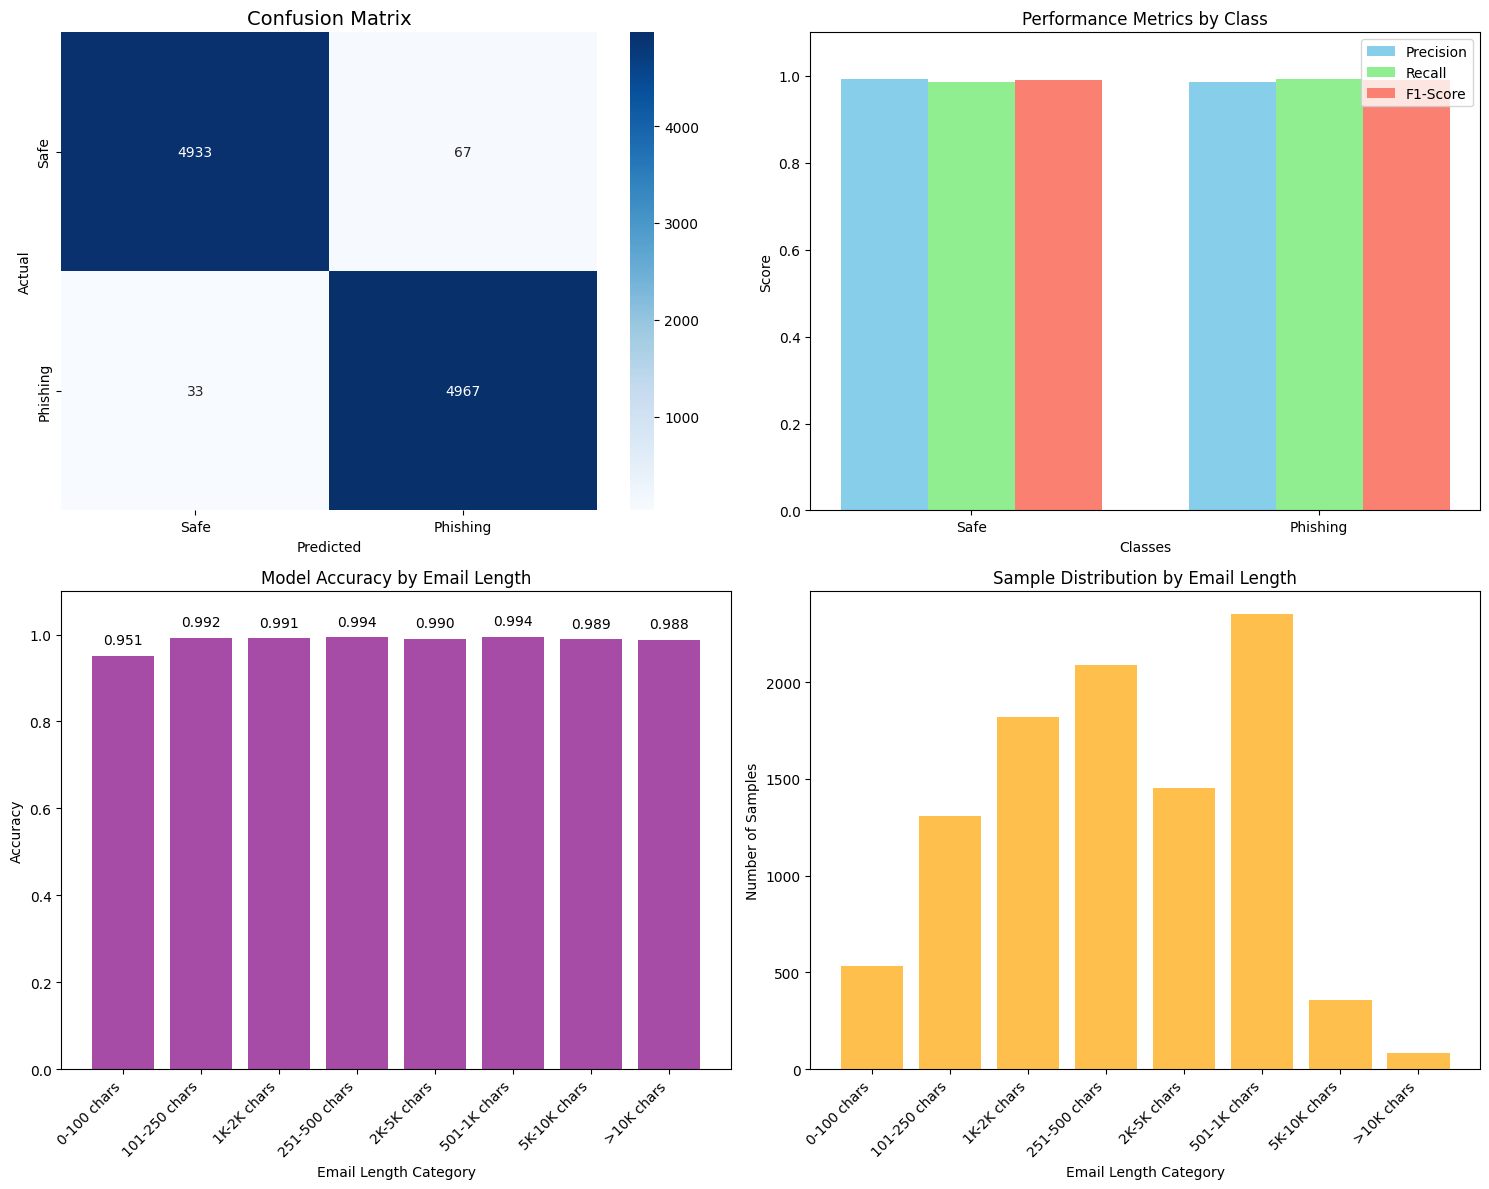


 SAVING RESULTS TO FILES
 Saved: phishing_predictions_detailed.csv
✅ Saved: phishing_evaluation_summary.txt
✅ Saved: phishing_errors_analysis.csv
✅ Saved: phishing_metrics_by_length.csv

                    
EVALUATION COMPLETE!
                    

 FINAL SUMMARY:
├── Overall Accuracy: 99.00%
├── Macro F1-Score: 0.9900
├── Total Samples Evaluated: 10,000
├── Total Errors: 100
└── Files Generated: 5


In [ ]:
metrics, errors = run_complete_evaluation(df, samples_per_class=5000)